In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize, OrdinalEncoder

In [2]:
df = pd.read_csv('data.csv')

/tmp/ipykernel_3371/1507164070.py:1: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


In [3]:
df = df.drop(['Unnamed: 0','submission_offset','submission_offset_2','submission_offset_2.1'], axis = 1)

In [4]:
df['year'] = pd.to_numeric(df['year'], errors = 'coerce')

In [5]:
df.drop_duplicates(subset = ['song','artist','album'],inplace = True)

In [6]:
lis = []
for d in df['true_genre']:
    if type(d) == str:
        d = d.lower()
        g = ''
        if 'jazz' in d:
            g = g + 'jazz/'
        if 'electronic' in d:
            g = g + 'electronic/'
        if ('folk' in d) or('country' in d):
            g = g + 'folkcountry/'
        if ('funk' in d) or ('soul' in d) or ('rnb' in d) or ('r&b' in d):
            g = g + 'funksoulrnb/'
        if 'pop' in d:
            g = g + 'pop/'
        if ('rap' in d) or (('hip' in d) and ('hop' in d)):
            g = g + 'rap/'
        if ('classical' in d) or ('baroque' in d):
            g = g + 'classical/'
        if 'alternative' in d:
            g = g + 'alternative/'
        if 'blues' in d:
            g = g+ 'blues/'
        if 'rock' in d:
            g = g + "rock"
        if g == '':
            lis.append(None)
        else:
            lis.append(g.strip("/"))
    else:
        lis.append(None)
        
df['genre_parse'] = lis

In [7]:
genre = df[df['genre_parse'].isnull() == False]

In [8]:
genre1 = genre[~genre['genre_parse'].str.contains('/')]

In [9]:
enc = OrdinalEncoder()
arr = enc.fit_transform(genre1[['key_scale','key_key']])
genre1['key_scale'],genre1['key_key'] = arr[:,0],arr[:,1]

/tmp/ipykernel_3371/1982126763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre1['key_scale'],genre1['key_key'] = arr[:,0],arr[:,1]


In [10]:
genre1 = genre1.dropna(subset = 'year')

In [11]:
genre2 = normalize(genre1.select_dtypes(include = 'number'), norm = 'max')

In [13]:
gy = genre1[(genre1['year']<= 1985) & (genre1['year']>=1950)]
gy1 = genre1[(genre1['year']<= 2015) & (genre1['year']>=1986)]
gy1 = resample(gy1,replace = False, n_samples = 131921)
len(gy)

131921

In [14]:
gy = pd.concat([gy,gy1])
gy = gy.sample(frac=1)
gy_y = gy['year']
gy_x = gy.drop('year',axis = 1)

In [15]:
gy_x = normalize(gy_x.select_dtypes(include = 'number'), norm = 'max')
# macs = gy_y.max()
# gy_y = gy_y/macs

In [16]:
#gy_x = normalize(gy_x.select_dtypes(include = 'number'), norm = 'max')
pca = PCA(n_components = 4)
trans = pca.fit_transform(gy_x)   
gy_xtr = gy_x[:150000]
gy_ytr = gy_y[:150000]
gy_xte = gy_x[150000:]
gy_yte = gy_y[150000:]
reg = LinearRegression().fit(gy_xtr,gy_ytr)
print("Linear regression R2:", str(reg.score(gy_xte,gy_yte)))
print("Linear regression MSE:",str(((sum(reg.predict(gy_xte)-gy_yte)**2)/len(gy_yte))**(1/2)))

Linear regression R2: 0.061484867161798684
Linear regression MSE: 30.753162877234782


In [17]:
regr = RandomForestRegressor(criterion = 'friedman_mse' ,max_depth = 1,random_state = 0).fit(gy_xtr, gy_ytr)
print("Random Forest Regressor R2:",str(regr.score(gy_xte,gy_yte)))
print("Linear regression MSE:",str(((sum(regr.predict(gy_xte)-gy_yte)**2)/len(gy_yte))**(1/2)))

Random Forest Regressor R2: 0.0366300647444775
Linear regression MSE: 27.927306919502946


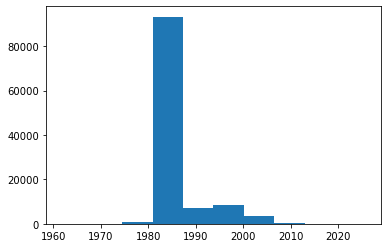

In [22]:
plt.hist(reg.predict(gy_xte));

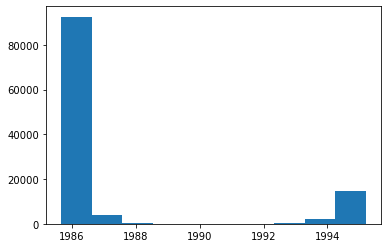

In [21]:
plt.hist(regr.predict(gy_xte));